# Step 1: Imports

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
import random

# Step 2: Defining Paths

In [2]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Set dataset paths
DATASET_DIR = "DAVIS/JPEGImages/480p"
ANNOTATION_DIR = "DAVIS/Annotations/480p"

# Set export directory
EXPORT_DIR = "./segmentation_model"

# Step 3: Train and Validation Split

In [3]:
def load_sequence(sequence):
    image_files = sorted(glob(os.path.join(DATASET_DIR, sequence, "*.jpg")))
    mask_files = sorted(glob(os.path.join(ANNOTATION_DIR, sequence, "*.png")))
    return list(zip(image_files, mask_files))

# Collect all sequences
all_sequences = os.listdir(DATASET_DIR)
all_image_mask_pairs = []
for seq in all_sequences:
    all_image_mask_pairs.extend(load_sequence(seq))

# Shuffle and split data
random.shuffle(all_image_mask_pairs)
train_pairs, val_pairs = train_test_split(all_image_mask_pairs, test_size=0.2, random_state=SEED)

# Step 4: Preprocessing Functions

In [ ]:
IMG_HEIGHT, IMG_WIDTH = 128, 224  # keep it small for TF.js compatibility

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0
    return img

def preprocess_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    mask = np.where(mask > 0, 1, 0).astype(np.float32)  # binary mask
    return np.expand_dims(mask, axis=-1)

# Augmentation function (applies to both image and mask consistently)
def augment_image_and_mask(image, mask):
    # Convert to tensor
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    mask = tf.convert_to_tensor(mask, dtype=tf.float32)

    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Random vertical flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Random brightness (images only)
    image = tf.image.random_brightness(image, max_delta=0.2)

    # Random rotation (90° steps)
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask = tf.image.rot90(mask, k)

    # ✅ Ensure shapes are consistent
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))

    # ✅ Ensure mask has single channel
    if mask.shape[-1] != 1:
        mask = tf.expand_dims(mask[..., 0], axis=-1)

    return image.numpy(), mask.numpy()


def data_generator(pairs, batch_size=8, augment=False):
    while True:
        for i in range(0, len(pairs), batch_size):
            batch = pairs[i:i + batch_size]
            imgs = []
            masks = []
            for p in batch:
                img = preprocess_image(p[0])
                mask = preprocess_mask(p[1])

                if augment:
                    img, mask = augment_image_and_mask(img, mask)

                imgs.append(img)
                masks.append(mask)

            yield np.array(imgs), np.array(masks)


# Step 5: Creating Model

In [5]:

from tensorflow.keras.applications import MobileNetV2

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x

def build_unet_with_mobilenet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Skip connections from MobileNetV2 layers
    skip1 = base_model.get_layer("block_1_expand_relu").output   # 112x56
    skip2 = base_model.get_layer("block_3_expand_relu").output   # 56x28
    skip3 = base_model.get_layer("block_6_expand_relu").output   # 28x14
    skip4 = base_model.get_layer("block_13_expand_relu").output  # 14x7
    x = base_model.output                                         # 4x7

    # Decoder with conv_block structure
    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same')(x)  # 8x14
    x = layers.Concatenate()([x, skip4])
    x = conv_block(x, 256)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)  # 16x28
    x = layers.Concatenate()([x, skip3])
    x = conv_block(x, 128)

    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)   # 32x56
    x = layers.Concatenate()([x, skip2])
    x = conv_block(x, 64)

    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x)   # 64x112
    x = layers.Concatenate()([x, skip1])
    x = conv_block(x, 32)

    x = layers.Conv2DTranspose(16, 3, strides=2, padding='same')(x)   # 128x224
    x = conv_block(x, 16)

    # Final output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

    model = keras.Model(inputs=base_model.input, outputs=outputs)
    return model

# Build and compile the model
model = build_unet_with_mobilenet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 112, 32)  864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 112, 32)  128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 112, 32)  0           ['bn_Conv1[0][0]']           

# Step 6: Model Training

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

BATCH_SIZE = 8
EPOCHS = 50

train_gen = data_generator(train_pairs, BATCH_SIZE, augment=True)  # ✅ Augmentation ON
val_gen = data_generator(val_pairs, BATCH_SIZE, augment=False)     # ❌ No augmentation

steps_per_epoch = len(train_pairs) // BATCH_SIZE
val_steps = len(val_pairs) // BATCH_SIZE

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,                # Stop after 5 epochs of no improvement
    restore_best_weights=True  # Restore best weights after stopping
)

model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

Epoch 1/50
620/620 [==============================] - 244s 394ms/step - loss: 0.2481 - accuracy: 0.9020 - val_loss: 2.0283 - val_accuracy: 0.6094
Epoch 2/50
620/620 [==============================] - 179s 286ms/step - loss: 0.1691 - accuracy: 0.9257 - val_loss: 4.7577 - val_accuracy: 0.5003
Epoch 3/50
620/620 [==============================] - 193s 312ms/step - loss: 0.1406 - accuracy: 0.9378 - val_loss: 0.7463 - val_accuracy: 0.8192
Epoch 4/50
620/620 [==============================] - 214s 346ms/step - loss: 0.1212 - accuracy: 0.9459 - val_loss: 3.4326 - val_accuracy: 0.5255
Epoch 5/50
620/620 [==============================] - 249s 402ms/step - loss: 0.1140 - accuracy: 0.9492 - val_loss: 2.4582 - val_accuracy: 0.5853
Epoch 6/50
620/620 [==============================] - 318s 513ms/step - loss: 0.1067 - accuracy: 0.9522 - val_loss: 0.5848 - val_accuracy: 0.8171
Epoch 7/50
620/620 [==============================] - 360s 581ms/step - loss: 0.0932 - accuracy: 0.9572 - val_loss: 0.7846 -

# Step 7: Model Testing

1/1 [==============================] - 6s 6s/step


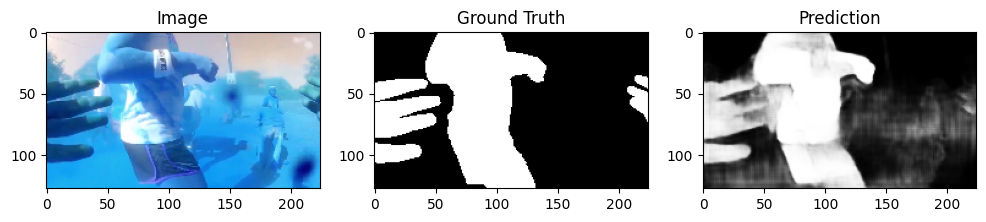

1/1 [==============================] - 0s 189ms/step


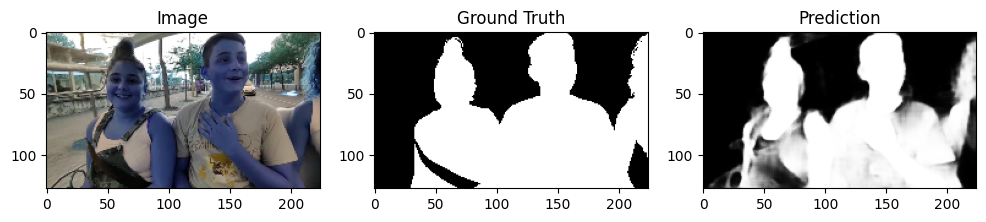

1/1 [==============================] - 0s 185ms/step


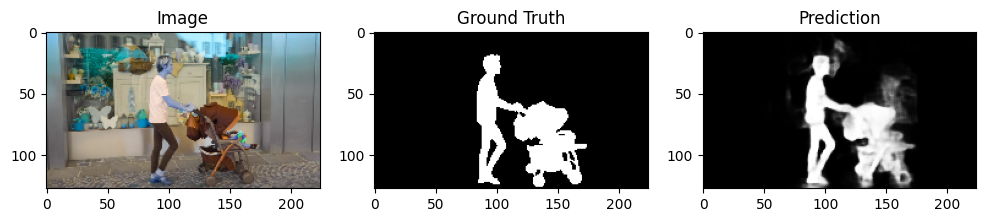

In [8]:
# model = keras.models.load_model(EXPORT_DIR)
def show_sample():
    img_path, mask_path = random.choice(val_pairs)
    img = preprocess_image(img_path)
    mask = preprocess_mask(mask_path)
    pred = model.predict(np.expand_dims(img, axis=0))[0]

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Image")
    plt.subplot(1,3,2); plt.imshow(mask.squeeze(), cmap='gray'); plt.title("Ground Truth")
    plt.subplot(1,3,3); plt.imshow(pred.squeeze(), cmap='gray'); plt.title("Prediction")
    plt.show()

# Run this cell to view random prediction
for i in range(3):
    show_sample()

1/1 [==============================] - 0s 235ms/step


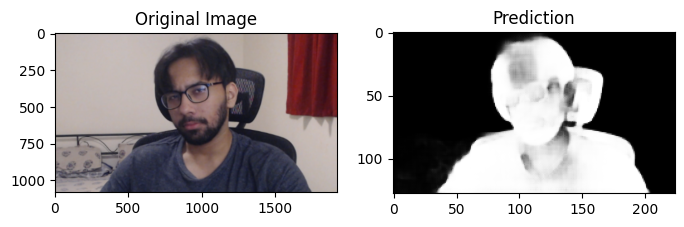

In [9]:
def test_on_custom_image(img_path):
    # Read and preprocess image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (IMG_WIDTH, IMG_HEIGHT))
    img_norm = img_resized / 255.0

    # Predict
    pred = model.predict(np.expand_dims(img_norm, axis=0))[0]

    # Show results
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(img_rgb); plt.title("Original Image")
    plt.subplot(1,2,2); plt.imshow(pred.squeeze(), cmap='gray'); plt.title("Prediction")
    plt.show()

# 🖼️ Example usage:
test_on_custom_image(r"C:\Users\Hamza\Desktop\test\frame.png")

# Step 8: Exporting Model

In [10]:
confirm = input("Do you want to export the model? Type 'y' to confirm: ")
if confirm.lower() == 'y':
    model.save(EXPORT_DIR)
    print("Model saved!")
else:
    print("Export cancelled.")

INFO:tensorflow:Assets written to: ./segmentation_model\assets


INFO:tensorflow:Assets written to: ./segmentation_model\assets


Model saved!


In [11]:
# Converitng the model to ONNX format
!python -m tf2onnx.convert --saved-model ./segmentation_model --output ../web-ui/public/model.onnx

c:\Users\Hamza\anaconda3\envs\gpu\lib\runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2025-08-10 17:01:47,856 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2025-08-10 17:01:52,721 - INFO - Signatures found in model: [serving_default].
2025-08-10 17:01:52,721 - WARNING - '--signature_def' not specified, using first signature: serving_default
2025-08-10 17:01:52,722 - INFO - Output names: ['conv2d_10']
2025-08-10 17:01:55,129 - INFO - Using tensorflow=2.10.1, onnx=1.17.0, tf2onnx=1.16.1/15c810
2025-08-10 17:01:55,129 - INFO - Using opset <onnx, 15>
2025-08-10 17:01:55,444 - INFO - Computed 0 values for constant folding
2025-08-10 17:01:55,944 - INFO - Optimizing ONNX model
2025-08-10 17:01:58,551 - INFO - After optimization: BatchNormalization -52 (62->10), Cast -5 (5->0), Concat -5 (9->4), Const